# Climate Change and Impacts in Africa

According to the [United Nations](https://www.un.org/en/climatechange/what-is-climate-change), Climate change refers to long-term shifts in temperatures and weather patterns. Such shifts can be natural, due to changes in the sun’s activity or large volcanic eruptions. But since the 1800s, **human activities** have been the main driver of climate change, primarily due to the burning of fossil fuels like coal, oil, and gas.

The consequences of climate change now include, among others, intense droughts, water scarcity, severe fires, rising sea levels, flooding, melting polar ice, catastrophic storms, and declining biodiversity.

You work for a Non-governmental organization tasked with reporting the state of climate change in Africa at the upcoming African Union Summit. The head of analytics has provided you with [IEA-EDGAR CO2 dataset](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117) which you will clean, combine and analyze to create a report on the state of climate change in Africa. You will also provide insights on the impact of climate change on African regions (with four countries, one from each African region, as case studies). 

## Dataset

*The dataset, IEA-EDGAR CO2, is a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version 7.0 (2022) including or based on data from IEA (2021) Greenhouse Gas Emissions from Energy, www.iea.org/statistics, as modified by the Joint Research Centre. The data source was the [EDGARv7.0_GHG website](https://edgar.jrc.ec.europa.eu/dataset_ghg70) provided by Crippa *et. al.* (2022) and with [DOI](https://data.europa.eu/doi/10.2904/JRC_DATASET_EDGAR).*

The dataset contains three sheets - `IPCC 2006`, `1PCC 1996`, and `TOTALS BY COUNTRY` on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021. **You can download the dataset from your workspace or inspect the dataset directly [here](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117)**.

### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |
| `ipcc_code_2006_for_standard_report_name` | The industry responsible for generating CO2 |

In [15]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing our datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
# Let's skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# we need only the African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')
temperatures

,Year,Ethiopia,Mozambique,Nigeria,Tunisia
0,1960,22.59,23.82,26.87,19.78
1,1961,22.30,24.00,26.28,19.67
2,1962,22.36,23.77,26.68,19.37
3,1963,22.56,23.27,27.02,19.33
4,1964,22.15,23.47,26.66,19.41
...,...,...,...,...,...
57,2017,23.65,24.43,27.46,20.72
58,2018,23.27,24.56,27.41,20.72
59,2019,23.41,24.81,27.29,20.73
60,2020,23.38,24.61,27.43,20.87


## 1 - Clean and tidy the datasets

In [16]:
ipcc_2006_africa = ipcc_2006_africa.rename(columns={'C_group_IM24_sh': 'Region', 'Country_code_A3': 'Code','ipcc_code_2006_for_standard_report_name': 'Industry'})

totals_by_country_africa = totals_by_country_africa.rename(columns={'C_group_IM24_sh':'Region','Country_code_A3': 'Code'})

# drop columns
ipcc_2006_africa = ipcc_2006_africa.drop(['IPCC_annex','ipcc_code_2006_for_standard_report',
'Substance'],axis=1)

totals_by_country_africa = totals_by_country_africa.drop(['IPCC_annex', 'Substance'], axis=1)

# Melt and clean Year column

def melt_clean(df):
    value_vars = list(filter(lambda x: x.startswith('Y_'), df.columns))
    id_vars = list(set(df.columns).difference(value_vars))

    # melt
    long = df.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='Year',
        value_name='CO2')

    # drop rows where co2 is missing
    long = long[~long.CO2.isnull()]

    # convert year to integer
    long.Year = long.Year.str.replace('Y_', '').astype(int)

    return long

ipcc_2006_africa = melt_clean(ipcc_2006_africa)
totals_by_country_africa = melt_clean(totals_by_country_africa)

,Region,Code,Name,Year,CO2
0,Southern_Africa,AGO,Angola,1970,20393.274068
1,Eastern_Africa,BDI,Burundi,1970,4385.562636
2,Western_Africa,BEN,Benin,1970,4318.786819
3,Western_Africa,BFA,Burkina Faso,1970,8158.106987
4,Southern_Africa,BWA,Botswana,1970,947.246888
...,...,...,...,...,...
2907,Southern_Africa,TZA,Tanzania_United Republic of,2021,89961.948758
2908,Eastern_Africa,UGA,Uganda,2021,90114.416852
2909,Southern_Africa,ZAF,South Africa,2021,486199.588051
2910,Southern_Africa,ZMB,Zambia,2021,36992.720366


## 2 - Show the trend of `CO2` levels across the African regions

Text(0.5, 1.0, 'CO2 levels across the African Regions between 1970 and 2021')

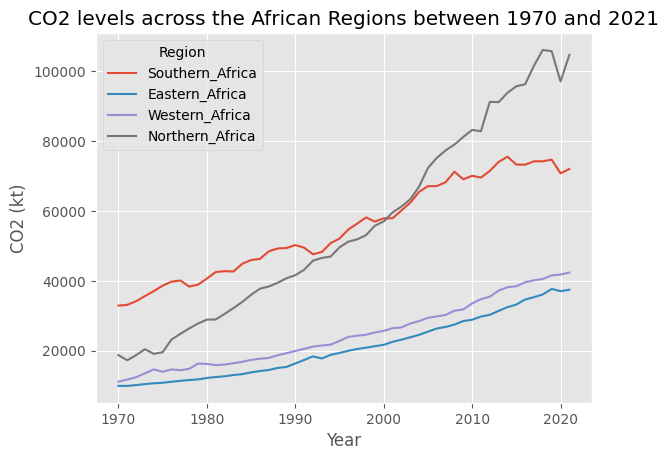

In [17]:
sns.lineplot(data=totals_by_country_africa, x='Year', y='CO2', hue='Region', ci=None)
plt.ylabel('CO2 (kt)')
plt.title('CO2 levels across the African Regions between 1970 and 2021')


## 3 - Determine the relationship between time (`Year`) and `CO2` levels across the African regions

In [28]:
relationship_btw_time_CO2 = totals_by_country_africa.groupby('Region')[['Year', 'CO2']].corr(method='spearman')
relationship_btw_time_CO2

Year       CO2
Region                                  
Eastern_Africa  Year  1.000000  0.181768
                CO2   0.181768  1.000000
Northern_Africa Year  1.000000  0.429875
                CO2   0.429875  1.000000
Southern_Africa Year  1.000000  0.260986
                CO2   0.260986  1.000000
Western_Africa  Year  1.000000  0.324071
                CO2   0.324071  1.000000

## 4 - Determine if there is a significant difference in the CO2 levels among the African Regions

In [25]:
aov_results = pingouin.anova(data=totals_by_country_africa, dv='CO2', between='Region')

pw_ttest_result = pingouin.pairwise_tests(data=totals_by_country_africa, dv='CO2',
between='Region', padjust="bonf").round(3)

print(aov_results)
print(pw_ttest_result)

   Source  ddof1  ddof2          F         p-unc       np2
0  Region      3   2908  35.558065  1.455509e-22  0.035385
  Contrast                A                B  ...  p-adjust       BF10  hedges
0   Region   Eastern_Africa  Northern_Africa  ...      bonf  1.554e+17  -0.801
1   Region   Eastern_Africa  Southern_Africa  ...      bonf  4.024e+08  -0.422
2   Region   Eastern_Africa   Western_Africa  ...      bonf      0.173  -0.059
3   Region  Northern_Africa  Southern_Africa  ...      bonf      0.079   0.005
4   Region  Northern_Africa   Western_Africa  ...      bonf  9.641e+10   0.418
5   Region  Southern_Africa   Western_Africa  ...      bonf  5.437e+05   0.335

[6 rows x 13 columns]


## 5 - Determine the most common (top 5) industries in each African region.

In [26]:
# Group the data by Region and Industry and count the occurrences
ipcc_grouped = ipcc_2006_africa.groupby(['Region', 'Industry']).size().reset_index(name='Count')

# Sort the data within each region group by Count in descending order
ipcc_grouped = ipcc_grouped.sort_values(['Region', 'Count'], ascending=[True, False])

# Get the top 5 industries for each region
top_5_industries = ipcc_grouped.groupby('Region').head(5).reset_index(drop=True)
top_5_industries

,Region,Industry,Count
0,Eastern_Africa,Residential and other sectors,1454
1,Eastern_Africa,Manufacturing Industries and Construction,1383
2,Eastern_Africa,Main Activity Electricity and Heat Production,1174
3,Eastern_Africa,Road Transportation no resuspension,742
4,Eastern_Africa,Glass Production,728
5,Northern_Africa,Residential and other sectors,572
6,Northern_Africa,Manufacturing Industries and Construction,456
7,Northern_Africa,Main Activity Electricity and Heat Production,315
8,Northern_Africa,Glass Production,312
9,Northern_Africa,Non-Energy Products from Fuels and Solvent Use,312


## 6 - Determine the industry responsible for the most amount of CO2 (on average) in each African Region

In [21]:
# Emissions per group
group_emissions = ipcc_2006_africa.groupby(['Region', 'Industry'])['CO2'].mean().reset_index()

# Industry with  the maximum CO2 emission
max_co2_industries = group_emissions.loc[group_emissions.groupby('Region')['CO2'].idxmax()].reset_index(drop=True)
print(max_co2_industries)

            Region                                       Industry           CO2
0   Eastern_Africa                  Residential and other sectors   7904.439282
1  Northern_Africa  Main Activity Electricity and Heat Production  13612.230148
2  Southern_Africa  Main Activity Electricity and Heat Production  11377.802504
3   Western_Africa                  Residential and other sectors   8702.936136


## 7 - Predict the `CO2` levels (at each African region) in the year 2025

In [27]:
# data
newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)

reg = LinearRegression()
target = np.log10(totals_by_country_africa['CO2'])
features = pd.get_dummies(totals_by_country_africa[['Year', 'Region']])
reg.fit(features, target)
predicted_co2 = reg.predict(newdata)
predicted_co2 = np.round(10**predicted_co2, 2)
predicted_co2

array([15177.72, 10788.07, 37761.69, 41081.9 ])

## 8 - Determine if CO2 levels affect annual temperature in the selected African countries

![relationship between co2 and temp](co2_temp.png)

In [23]:
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries = totals_by_country_africa[['Name', 'Year', 'CO2']].query('Name in @countries')

temp_long = temperatures.melt(id_vars=['Year'],value_vars=countries,var_name='Name',
value_name='Temperature')

joined = pd.merge(selected_countries, temp_long, on=['Name', 'Year'], how='inner')

model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          1.22e-182
Time:                        11:16:54   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""